1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import pandas as pd
import seaborn as sns
import scipy.stats

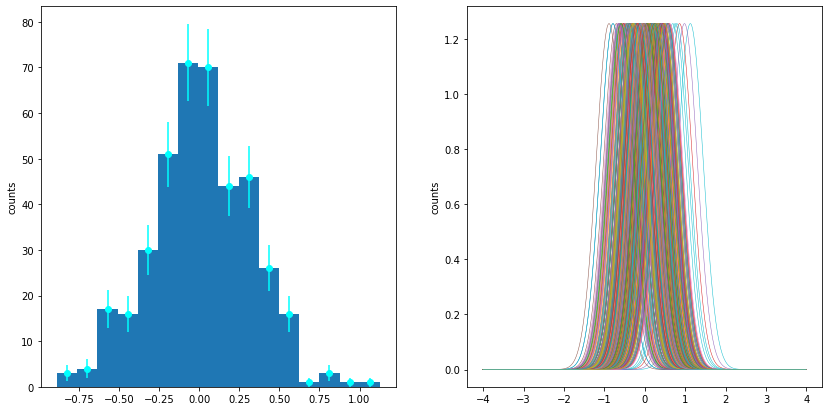

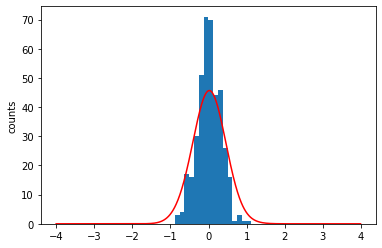

In [4]:
N = 400
std = 1
mean = 0



k = np.arange(-4,4,0.01)
std = 1.06*x.std()*np.power(len(x),-1/5)

#plt.plot(k,m)
#plt.ylabel('counts')
#plt.show()


#print(norm)


fig = plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
x = np.random.normal(mean, std, N)
n, bins, _ = plt.hist(x, bins=16)
plt.ylabel('counts')

mean_bins = 1/2 * ( bins[1:]+bins[:-1])
err = np.sqrt(np.abs(n))

plt.errorbar(mean_bins, n, xerr = 0, yerr = err, fmt='o',color="cyan")

plt.subplot(1,2,2)
[plt.plot(k,scp.stats.norm.pdf(k,x[i],scale = std), lw=0.5) for i in range(len(x))]
plt.ylabel('counts')

plt.show()


m = np.sum([scp.stats.norm.pdf(k,x[i],scale = std) for i in range(len(x))],axis=0)
#plt.plot(k,m)
#plt.ylabel('counts')
#plt.show()

norm = scp.integrate.trapz(m,k)
normhist = (bins[1]-bins[0])*np.sum(n)

g = m*normhist/norm

plt.hist(x, bins=16)
plt.plot(k,g,color="r")
plt.ylabel('counts')
plt.show()
#print(norm)

In [5]:
print(norm)

400.00000000000006


[2.14626532e-22 2.92522386e-22 3.98297741e-22 5.41788354e-22
 7.36248843e-22 9.99522958e-22 1.35560812e-21 1.83674490e-21
 2.48620462e-21 3.36200454e-21 4.54185408e-21 6.12973314e-21
 8.26463208e-21 1.11321514e-20 1.49798811e-20 2.01377695e-20
 2.70450735e-20 3.62859774e-20 4.86366222e-20 6.51271342e-20
 8.71233520e-20 1.16434396e-19 1.55454102e-19 2.07346790e-19
 2.76291011e-19 3.67799019e-19 4.89135092e-19 6.49862666e-19
 8.62559252e-19 1.14374956e-18 1.51512224e-18 2.00511463e-18
 2.65097488e-18 3.50144228e-18 4.62022749e-18 6.09052676e-18
 8.02087110e-18 1.05526974e-17 1.38701380e-17 1.82126656e-17
 2.38914088e-17 3.13101830e-17 4.09925696e-17 5.36167464e-17
 7.00602425e-17 9.14573836e-17 1.19272950e-16 1.55396521e-16
 2.02263193e-16 2.63007882e-16 3.41662333e-16 4.43406417e-16
 5.74888313e-16 7.44632047e-16 9.63555663e-16 1.24562937e-15
 1.60871062e-15 2.07560249e-15 2.67539379e-15 3.44515395e-15
 4.43207455e-15 5.69617208e-15 7.31369566e-15 9.38141886e-15
 1.20220395e-14 1.539096

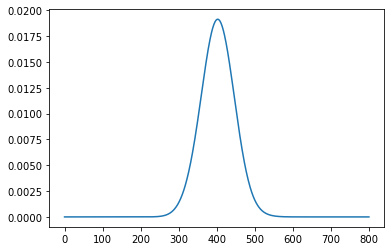

7520.7247315566465


In [6]:
k=np.zeros(N)
for i in range(N):
    k[i]=g[i]
print(k)
area=np.trapz(k, dx=1)
print(area)
plt.plot(g/area)
plt.show()
j=np.std(g)
#print(j)
area=np.trapz(k, dx=1/std)
print(area)

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

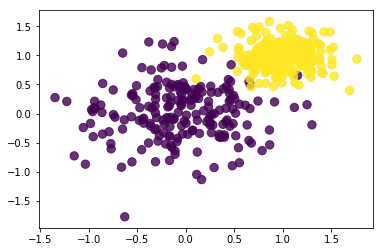

In [7]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

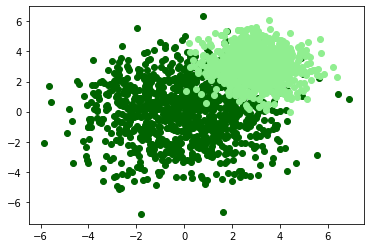

In [8]:
N = 1000

def Gauss_2d(mu, sigma):
    x = np.random.normal(loc = mu, scale = sigma, size = N)
    y = np.random.normal(loc = mu, scale = sigma, size = N)
    return (x, y)

x1,y1 = Gauss_2d(0,2)
x2,y2 = Gauss_2d(3,1)

plt.scatter(x1,y1, color = 'darkgreen')
plt.scatter(x2,y2, color = 'lightgreen')

plt.show()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [9]:
#! wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

In [10]:
j=pd.DataFrame(np.load("residuals_261.npy", allow_pickle=True).item())
#print(j)
df=j[(abs(j["residuals"])<2)]
#print(df)
#g=scipy.stats.linregress(i["residuals"], i["distances"])
#
#sns.jointplot(y=df["residuals"], x=df["distances"],kind="reg")
#print(df["distances"].max())

<ipython-input-11-fa2b0fab215f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin'] = np.digitize(df['distances'], binedges)


Text(27.0, 0.5, 'Residuals')

<Figure size 720x720 with 0 Axes>

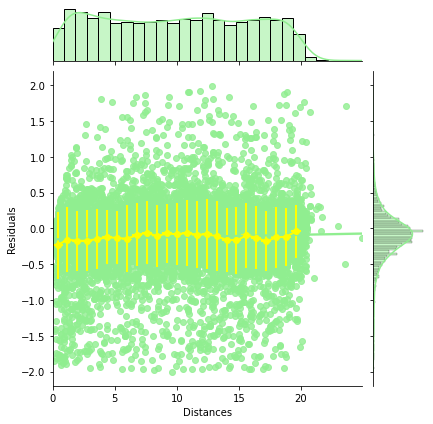

In [11]:
fig = plt.figure(figsize = (10,10))

plot = sns.jointplot(x=df["distances"], y=df["residuals"], data=df, kind= "reg", color="lightgreen")

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df['residuals'], df['distances'])

nbins = 25
xmin = 0
xmax = 20

binedges = xmin + ((xmax-xmin)/nbins) * np.arange(nbins+1)
bincenters = xmin + ((xmax-xmin)/nbins) * np.arange(nbins) + ((xmax-xmin)/(2*nbins))

x = bincenters 

df['bin'] = np.digitize(df['distances'], binedges)
ProfileFrame = pd.DataFrame({'bincenters' : bincenters, 'N' : df['bin'].value_counts(sort=False)},index=range(1,nbins+1))
bins = ProfileFrame.index.values

for bin in bins:
    ProfileFrame.loc[bin,'ymean'] = df.loc[df['bin']==bin,'residuals'].mean()
    ProfileFrame.loc[bin,'yStandDev'] = df.loc[df['bin']==bin,'residuals'].std()
    ProfileFrame.loc[bin,'yMeanError'] = ProfileFrame.loc[bin,'yStandDev'] #/ np.sqrt(ProfileFrame.loc[bin,'N'])

plt.errorbar(ProfileFrame['bincenters'],ProfileFrame['ymean'], xerr=(xmax-xmin)/(2*nbins),linewidth=2, yerr=ProfileFrame['yMeanError'],label='Profile Plot', color='yellow',marker='o')
plt.xlabel('Distances')
plt.ylabel('Residuals')